## Setting

In [1]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
pd.set_option('display.max_columns', None)

train.shape, test.shape

((20000, 23), (10000, 22))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

f_path = 'C:\Windows\Fonts\malgun.ttf'
font_manager.FontProperties(fname=f_path).get_name()

from matplotlib import rc
rc('font', family='Malgun Gothic')

## 문제
개인적 특성을 바탕으로 한 데이터를 활용하여 **소득 수준을 예측**하는 것을 목표로 한다.
다양한 개인적 특성 데이터를 분석하고 이해하는 능력을 키우며, 이를 통해 ai 역량과 경험을 발전시키는 것

<br>

개인의 특성과 관련된 다양한 데이터를 활용하여 개인 소득 수준을 예측할 수 있는 AI 모델 개발


### Train dataset EDA

In [3]:
train.columns.symmetric_difference(test.columns)

Index(['Income'], dtype='object')

- 종속변수 'Income'

- ID : 아이디
- Age : 나이
- Gender : 성
- Education_status : 최종학력
- Employment_Status : 고용상태
- Working Week(Yearly) : 1년간 근무 주
- Industry_Status : 근무 산업군
- Occupation_Status : 직업
- Race : 인종
- Hispanic_Origin : 히스패닉 출신
- Martial_Status : 결혼여부
- Household_Status : 세대 현황
- Household_Summery : 세대주 여부
- Citizenship : 시민권 여부
- Birth_Country : 출생국가 (본인/부/모)
- Tax_Status : 세금
- Gains : 이익
- Losses : 손실
- Dividends : 배당금
- Income_status : 소득상태
- Income : 1시간 단위의 소득 (예측목표)

In [4]:
train.head()

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,Householder,Householder,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,Householder,Householder,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570


### 수치형 EDA 및 전처리

In [35]:
#일단 눈에 띄는 이상치 삭제 #Age 0 값 존재
train = train[train['Age'] != 0]
test = test[test['Age'] != 0]

? Income이 0인 데이터는 삭제해도 되는 걸까? AI 역량 강화이기 때문에 이상치가 아니라 학습 데이터로 인식해서 어린아이들인 경우 소득이 0일 것이라고 예측하는 것이 현재 상황에 더 적절한 것 같다.

In [39]:
#0살을 삭제하니 나이에 1살이 있는데,어린이들이므로 넘어간다.
#최댓값이 99999
# test[test['Gains'] == test['Gains'].max()] # 99999가 18개
# test[test['Dividends'] == test['Dividends'].max()] #99999가 1개

#Gains 이상치 삭제1 : 30개 삭제
train.drop(index = train[train['Gains'] == train['Gains'].max()].index, inplace=True)

#Income 이상치 삭제1 : 1개 삭제
train.drop(index = train[train['Income'] == train['Income'].max()].index, inplace=True)


#Gains 이상치 삭제1 
test.drop(index = test[test['Gains'] == test['Gains'].max()].index, inplace=True)

#Dividends 이상치 삭제1
test.drop(index = test[test['Dividends'] == test['Dividends'].max()].index, inplace=True)

In [42]:
train[train['Dividends'] == train['Dividends'].max()]
#배당금 가격이 월등히 큰 것을 제외하고는 큰 이상치가 없다고 판단하여 일시보류

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
401,TRAIN_00401,74,F,High Senior,Full-Time,48,Medical (except Hospitals),Professional,White,All other,Married,Spouse of householder,Spouse of householder,Native,US,US,US,Married Filling Jointly both over 65 (MFJ),0,0,45000,Over Median,500


In [43]:
#EDA 함수

def eda_box(value): #박스플롯, 수치형
    plt.figure(figsize=(10,4))
    sns.boxplot(value, palette='Set1')
    plt.xticks(rotation=45)
    plt.show()

def eda_bar(value): #바 플롯, 범주형
    plt.figure(figsize=(10,4))
    sns.barplot(value, palette='Set1')
    plt.xticks(rotation=45)
    plt.show()   

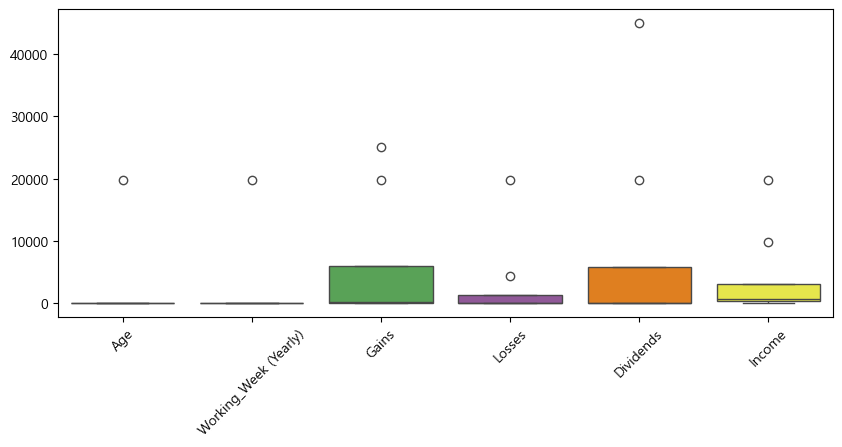

In [44]:
#수치형 describe
eda_box(train.describe())

In [54]:
train[train['Income'] == train['Income'].max()] 
#정제후 가장 높은 수입을 가진 사람이 25살 군인 아내 고졸 교통 관련 사무로 이상치가 예상됨. 
#그 다음 최대값들을 가진 행들을 살펴본다

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
9869,TRAIN_09869,25,F,High graduate,Full-Time,45,Transportation,Admin Support (include Clerical),White,All other,Married (Armed Force Spouse),Spouse of householder,Spouse of householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,30,Under Median,9900


In [88]:
#Income이 상위인데 Income Status가 under median
train['Income_Status'].value_counts()

Under Median    13131
Unknown          5976
Over Median       709
Name: Income_Status, dtype: int64

<Axes: >

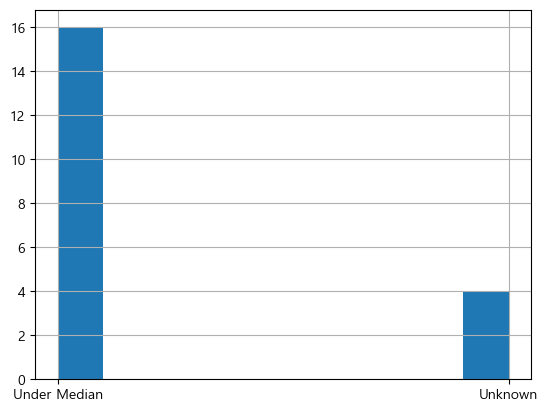

In [82]:
income_top20 = train.sort_values(by='Income', ascending=False)[:20] #위 상위 Income의 Income Status는 대부분 under median으로 이상치 의심
#top_20_income = train['Income'].nlargest(20)
income_top20['Income_Status'].hist()

array([[<Axes: title={'center': 'Income'}>]], dtype=object)

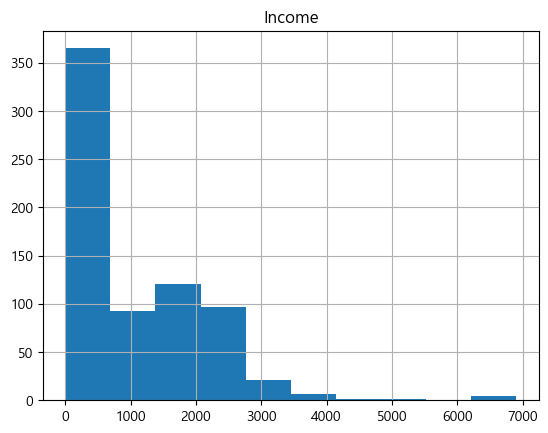

In [73]:
# pd.crosstab(train['Income_Status'], train['Income'])
income_standard = train[['Income_Status', 'Income']]

#over median의 경우
income_standard[income_standard['Income_Status'] == 'Over Median'].hist()

In [103]:
train[(income_standard['Income_Status'] == 'Over Median') & (income_standard['Income'] == 0)]

#####################################Over Median이면서 Gains와 Losses Income이 모두 0인 데이터가 가능한가? 이걸 여기서 어떻게 판단할 것인가?###################################################
# 반드시 income status와 income의 크기가 비례하는 것은 아님. 그렇다면 연관성이 얼마나 되는지 체크

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
14,TRAIN_00014,44,M,High graduate,Children or Armed Forces,52,Public Administration,Protective Services,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,200,Over Median,0
34,TRAIN_00034,55,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Machine Operators & Inspectors,Native American/Aleut/Eskimo,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,48,Over Median,0
37,TRAIN_00037,57,M,Bachelors degree,Full-Time,52,Public Administration,Management,White,All other,Married (Spouse Absent),Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Over Median,0
84,TRAIN_00084,52,M,High graduate,Full-Time,52,Construction,Craft & Repair,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),15024,0,0,Over Median,0
91,TRAIN_00091,35,M,Doctorate degree,Full-Time,52,Finance Insurance & Real Estate,Management,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,200,Over Median,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,TRAIN_19561,76,M,Professional degree,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,Married,Householder,Householder,Native,US,Italy,Unknown,Married Filling Jointly both over 65 (MFJ),0,0,0,Over Median,0
19581,TRAIN_19581,46,M,College,Children or Armed Forces,52,Not in universe or children,Unknown,White,Mexican-American,Divorced,Nonfamily householder,Householder,Native,US,Mexico,Mexico,Single,0,0,325,Over Median,0
19752,TRAIN_19752,45,M,Bachelors degree,Full-Time,52,Construction,Management,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,2000,Over Median,0
19779,TRAIN_19779,45,F,High graduate,Children or Armed Forces,50,Medical (except Hospitals),Services,Black,All other,Married (Spouse Absent),Householder,Householder,Native,US,US,US,Head of Household (HOH),0,0,0,Over Median,0


array([[<Axes: title={'center': 'Income'}>]], dtype=object)

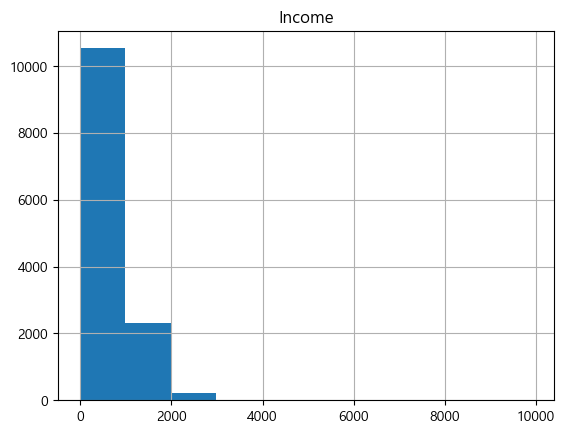

In [75]:
#under median의 경우
income_standard[income_standard['Income_Status'] == 'Under Median'].hist()

array([[<Axes: title={'center': 'Income'}>]], dtype=object)

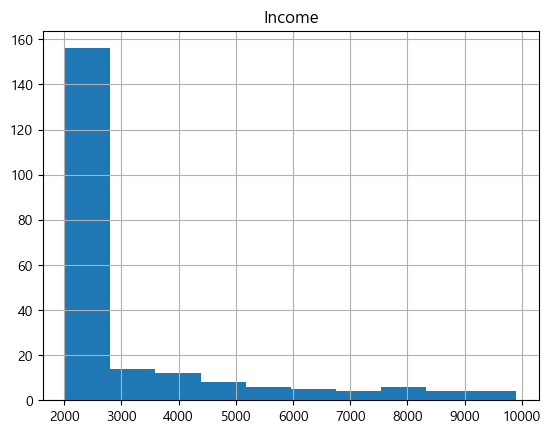

In [93]:
#under median의 경우
b = income_standard[income_standard['Income_Status'] == 'Under Median']
b[b['Income'] > 2000].hist()

array([[<Axes: title={'center': 'Income'}>]], dtype=object)

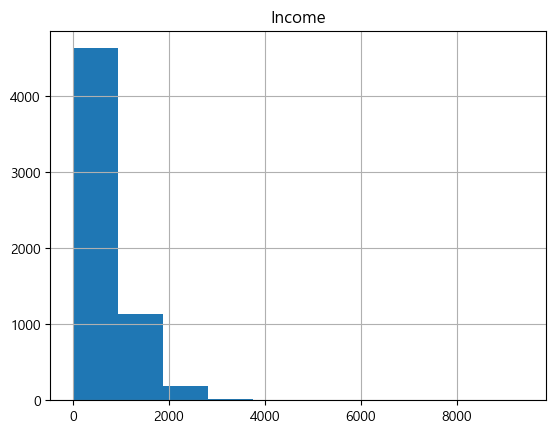

In [76]:
#unknown의 경우
income_standard[income_standard['Income_Status'] == 'Unknown'].hist()

**상위 20위 안에서 Income_Status가 'Under Median'인 rows를 이상치로 판단하여 삭제**
- train_1 : income의 이상치 부분 정리

In [167]:
# 상위 20개의 값을 가진 행 중 'Income_Status'가 'Under Median'가 아닌 행을 선택
train_1 = train[~((train['Income'].isin(income_top20)) & (train['Income_Status'] == 'Under Median'))]

<Axes: >

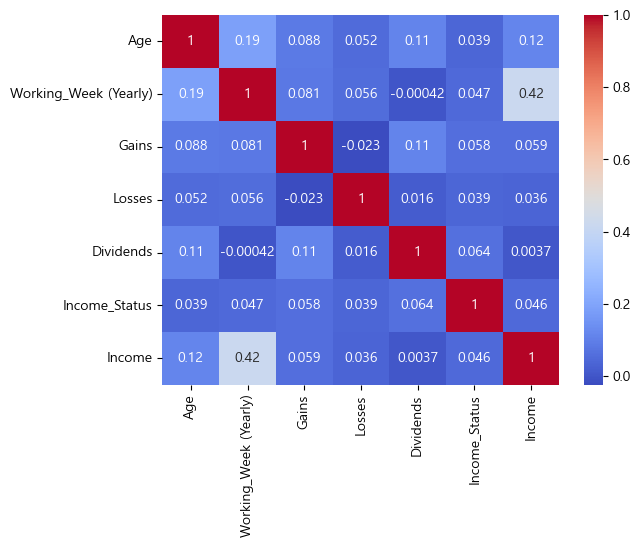

In [119]:
#income_Status와 income의 상관관계 확인
train_copy = train_1.copy()
train_copy['Income_Status'] = train_copy['Income_Status'].replace({'Unknown':0, 'Under Median':1, 'Over Median':2})

sns.heatmap(train_copy.corr(), annot=True, cmap='coolwarm')


**이어서 Income_Status의 경우 Income과의 상관관계는 낮으나 Unknown값이 많고 Income 과의 관계가 불명확하여 삭제**

근무 주 카테고리화

<Axes: >

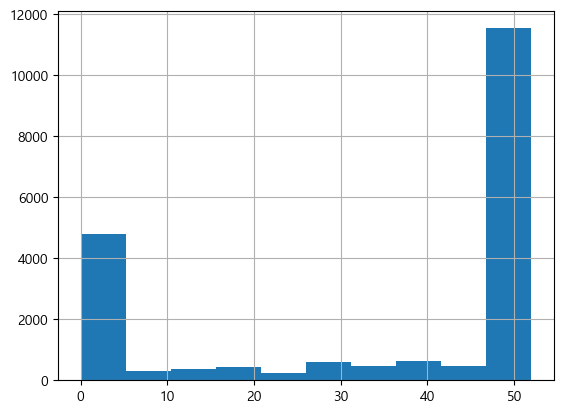

In [168]:
train_1['Working_Week (Yearly)'].hist()

In [169]:
# 근무 주 카테고리 화 하기
#52시간, 0 유지, 3개월 이하 1, 3개월과 6개월 사이 2, 6개월과 9개월 사이 3, 9개월 52주 전  4

def cal_months(data):
    if data == 52:
        return 5
    elif data == 0:
        return 0
    else:
        return (data // 13) + 1

train_1['Working_Week (Yearly)'] = train_1['Working_Week (Yearly)'].apply(cal_months)


In [170]:
train_1['Working_Week (Yearly)'].value_counts()

5    10577
0     4574
4     1991
3     1134
2      802
1      738
Name: Working_Week (Yearly), dtype: int64

### 범주형

C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


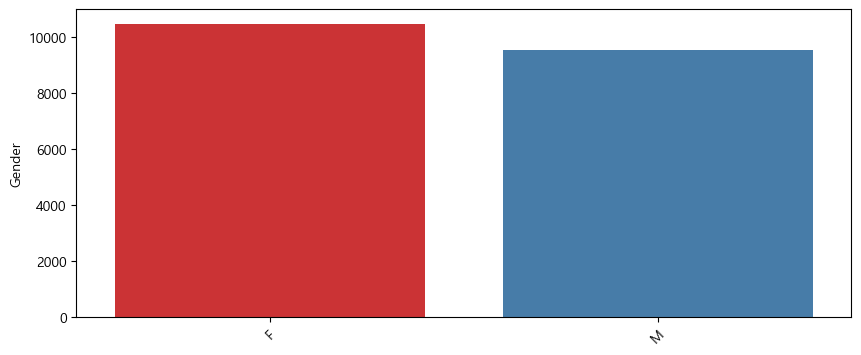

In [8]:
#(2) 성별
eda_bar(train['Gender'].value_counts())

In [9]:
# (3) Education_Status
train['Education_Status'].unique()

array(['Middle (7-8)', 'Associates degree (Vocational)', 'High graduate',
       'Masters degree', 'Bachelors degree', 'High Freshman',
       'Elementary (1-4)', 'College', 'Children', 'High Sophomore',
       'Associates degree (Academic)', 'High Junior', 'Elementary (5-6)',
       'Doctorate degree', 'Professional degree', 'High Senior',
       'Kindergarten'], dtype=object)

<Axes: ylabel='Education_Status'>

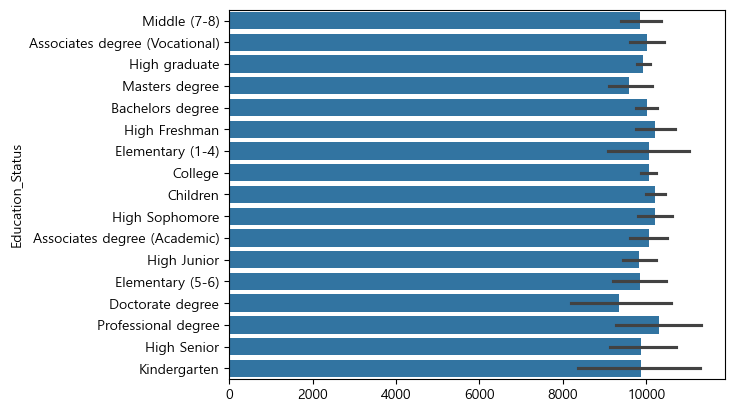

In [10]:
sns.barplot(train['Education_Status'])

**Education_Status 분류가 다양해서 상위 분류로 묶어서 인코딩 진행** <br>
<br>
- 유치원 이하 : Children, Kindergarten
- 초등학교 : Elementary(1-4), Elementary(5-6)
- 중고등학교 : High graduate, High Freshman, High Junior, High Sophomore, Middle(7-8), High Senior
- 대학교(학사, 준학사) : Bachelors degree, Associates degree(Vocational), College, Associates degree(Academic)
- 대학원(석사, 박사, 전문학사) : Master degree, Doctorate degree, Professional degree

C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


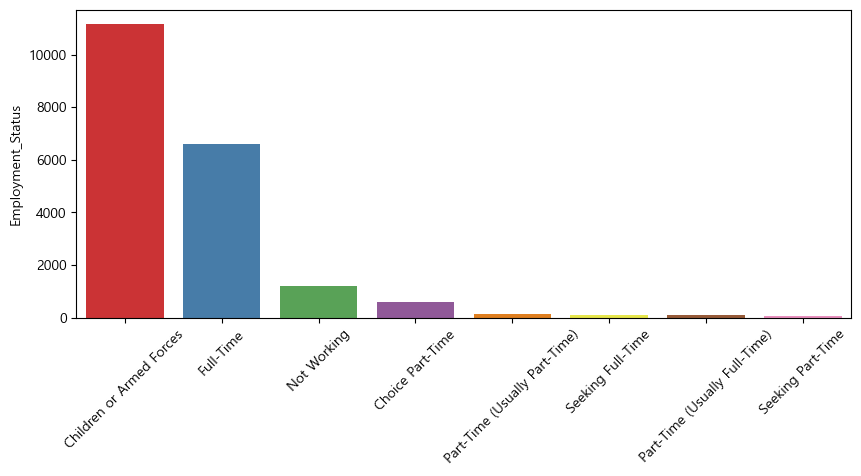

In [11]:
#(4) Employment_Status
eda_bar(train['Employment_Status'].value_counts())

In [12]:
train['Employment_Status'].value_counts()

Children or Armed Forces         11142
Full-Time                         6588
Not Working                       1221
Choice Part-Time                   593
Part-Time (Usually Part-Time)      158
Seeking Full-Time                  121
Part-Time (Usually Full-Time)      100
Seeking Part-Time                   77
Name: Employment_Status, dtype: int64

**Employment_Status (고용 형태) 상위 분류로 정리** 
<br>
- 'Children or Armed Forces'
- 'Full-Time'
- 'Not Working'
-  Part-Time : 'Choice Part-Time', 'Part-Time (Usually Part-Time)
- Between Jobs (구직 중) : 'Seeking Full-Time', 'Seeking Part-Time'

<BarContainer object of 24 artists>

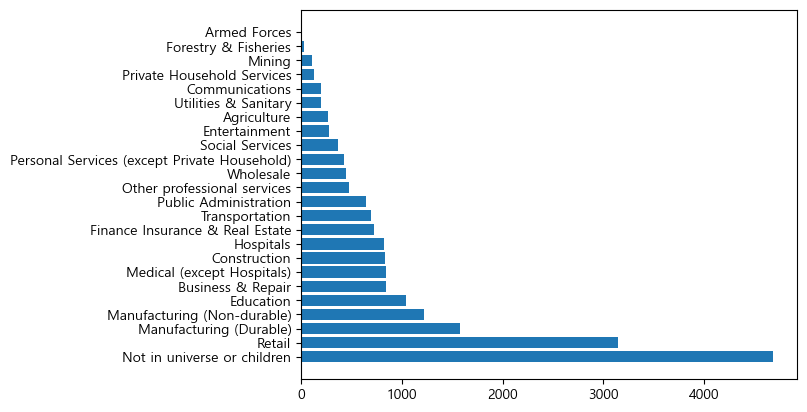

In [13]:
#(5) Industry_Status
industry_counts = train['Industry_Status'].value_counts()

# 수정된 코드
plt.barh(industry_counts.index, industry_counts.values)

In [14]:
industry_counts

Not in universe or children                     4688
Retail                                          3149
Manufacturing (Durable)                         1575
Manufacturing (Non-durable)                     1223
Education                                       1041
Business & Repair                                847
Medical (except Hospitals)                       838
Construction                                     832
Hospitals                                        821
Finance Insurance & Real Estate                  727
Transportation                                   693
Public Administration                            641
Other professional services                      477
Wholesale                                        450
Personal Services (except Private Household)     429
Social Services                                  367
Entertainment                                    278
Agriculture                                      268
Utilities & Sanitary                          

In [15]:
#(6) Occupation_Status
train['Occupation_Status'].value_counts()

Unknown                             4688
Admin Support (include Clerical)    2709
Services                            2313
Craft & Repair                      1869
Sales                               1692
Professional                        1488
Machine Operators & Inspectors      1383
Management                          1111
Handlers/Cleaners                    837
Transportation                       690
Technicians & Support                558
Farming & Forestry & Fishing         296
Protective Services                  260
Private Household Services           105
Armed Forces                           1
Name: Occupation_Status, dtype: int64

**직업상태에서 unknown이 다수를 차지해 이에 대한 전처리가 필요한데, 현재 열의 수가 많아 삭제하는 것이 유리할 것으로 판단**

C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


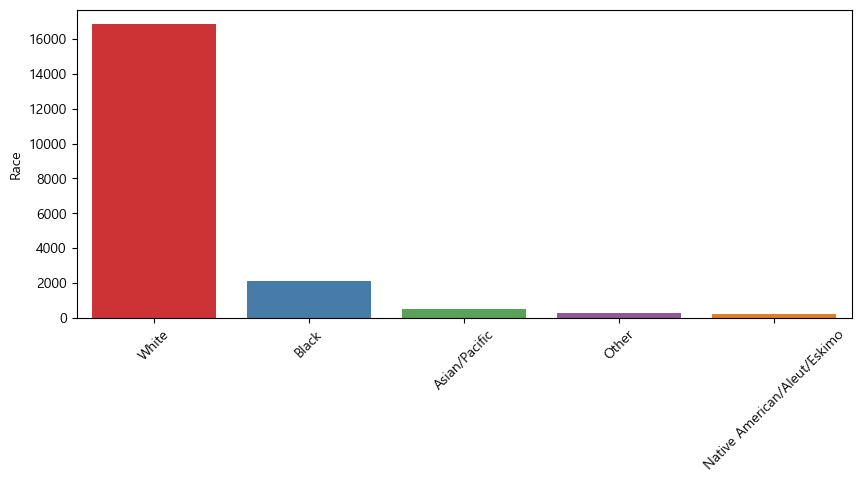

In [16]:
#(7) Race
eda_bar(train['Race'].value_counts())

In [17]:
#(8) Hispanic_Origin
train['Hispanic_Origin'].value_counts()

 All other                    17769
 Mexican-American               654
 Mexican (Mexicano)             624
 Central or South American      325
 Puerto Rican                   243
 Other Spanish                  201
 Cuban                           76
 NA                              59
 Chicano                         27
 Do not know                     22
Name: Hispanic_Origin, dtype: int64

hispanic_origin이 race와 상하위 관계로 예상되어 연관성이 어떻게 되는지 확인하고, 상관관계가 크지 않은지, 다중공선성은 없는지 파악이 필요

In [18]:
pd.crosstab(train['Race'], train['Hispanic_Origin'])

Hispanic_Origin,All other,Central or South American,Chicano,Cuban,Do not know,Mexican (Mexicano),Mexican-American,NA,Other Spanish,Puerto Rican
Race,,,,,,,,,,
Asian/Pacific,504,4,0,0,0,0,0,2,1,0
Black,2080,18,0,2,0,1,0,2,11,8
Native American/Aleut/Eskimo,214,0,0,0,0,8,3,0,1,0
Other,67,33,10,1,0,73,41,1,16,54
White,14904,270,17,73,22,542,610,54,172,181


In [19]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

correlation = cramers_v(train['Race'], train['Hispanic_Origin'])
print(f"Cramer's V between Race and Hispanic_Origin: {correlation}")

Cramer's V between Race and Hispanic_Origin: 0.16136343655234947


Race와 Hispanic_Origin는 상관관계가 있으나 약한 것으로 추정

C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


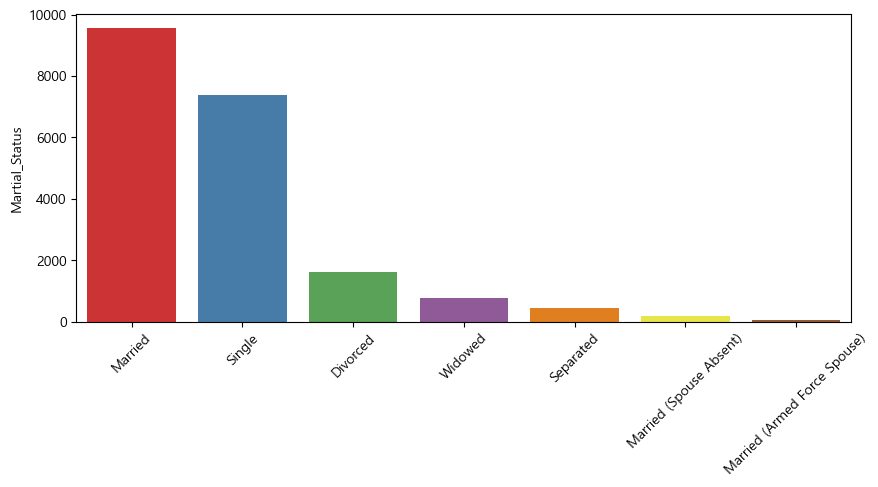

In [20]:
#(9) Martial_Status
eda_bar(train['Martial_Status'].value_counts())

**Martial_Status : Married를 하나로 합치는 전처리 필요**
<br>
- Martial_Status : Martial_Status 단어가 있으면 모두
- Single
- 결혼 경험 카테고리 생성 'Had been married' : 'Divored', 'Widowed', 'Separated'

In [21]:
train['Household_Status'].value_counts() #세대주

Householder                                                               6087
Spouse of householder                                                     4794
Child <18 never marr not in subfamily                                     2670
Nonfamily householder                                                     2465
Child 18+ never marr Not in a subfamily                                   1860
Secondary individual                                                       845
Other Rel 18+ never marr not in subfamily                                  195
Other Rel 18+ ever marr not in subfamily                                   154
Child 18+ ever marr Not in a subfamily                                     118
Child 18+ ever married Responsible Person of subfamily                     101
Child 18+ never married Responsible Person of subfamily                     96
Grandchild <18 never married child of subfamily Responsible Person          88
Responsible Person of unrelated subfamily           

In [22]:
train['Household_Status'].nunique()

31

In [23]:
train['Household_Summary'].value_counts()

Householder                             8552
Spouse of householder                   4794
Child under 18 never married            2679
Child 18 or older                       2192
Nonrelative of householder               974
Other relative of householder            781
Group Quarters- Secondary individual      24
Child under 18 ever married                4
Name: Household_Summary, dtype: int64

**Household_Status 삭제 summary으로 대체** 

In [24]:
train['Birth_Country'].unique()

array(['US', 'Cuba', 'Portugal', 'Mexico', 'Puerto-Rico', 'Germany',
       'Japan', 'Columbia', 'Philippines', 'Unknown', 'Italy',
       'Trinadad&Tobago', 'South Korea', 'Iran', 'England', 'India',
       'Vietnam', 'France', 'Scotland', 'Ecuador', 'China',
       'Outlying-U S (Guam USVI etc)', 'Nicaragua', 'Peru', 'Canada',
       'Jamaica', 'Dominican-Republic', 'Poland', 'Hong Kong', 'Thailand',
       'Cambodia', 'Guatemala', 'Laos', 'Yugoslavia', 'Haiti', 'Ireland',
       'El-Salvador', 'Panama', 'Honduras', 'Greece', 'Hungary', 'Taiwan',
       'Holand-Netherlands'], dtype=object)

In [25]:
train['Birth_Country (Father)'].unique()

array(['US', 'Cuba', 'Portugal', 'Mexico', 'Unknown', 'Puerto-Rico',
       'Germany', 'Japan', 'Poland', 'Columbia', 'Philippines', 'Italy',
       'Trinadad&Tobago', 'England', 'South Korea', 'Iran', 'France',
       'India', 'China', 'Dominican-Republic', 'Scotland', 'Ecuador',
       'Nicaragua', 'Peru', 'Cambodia', 'Canada', 'Jamaica', 'Vietnam',
       'Hong Kong', 'Thailand', 'Haiti', 'Guatemala', 'Laos',
       'Yugoslavia', 'Ireland', 'El-Salvador', 'Panama', 'Honduras',
       'Greece', 'Outlying-U S (Guam USVI etc)', 'Hungary', 'Taiwan',
       'Holand-Netherlands'], dtype=object)

In [26]:
print("Birth_Country 종류", train['Birth_Country'].nunique())
print("Birth_Country (Father) 종류", train['Birth_Country (Father)'].nunique())
print("Birth_Country (Mother) 종류", train['Birth_Country (Mother)'].nunique())

Birth_Country 종류 43
Birth_Country (Father) 종류 43
Birth_Country (Mother) 종류 43


**Birth_Country 태어난 국가가 43개로 US, Mid-South America, East Asia, Africa, Europe, South Asia 등으로 상위 분류 진행**
<br>
- North America : 'US', 'Outlying-U S (Guam USVI etc)', 'Canada',
- Mid-South America : 'Cuba',  'Mexico', 'Puerto-Rico', 'Columbia', 'Trinadad&Tobago', 'Ecuador', 'Nicaragua', 'Peru', 'Jamaica', 'Dominican-Republic', 'Haiti', 'Guatemala', 'El-Salvador', 'Panama', 'Honduras'
- East Asia : 'Japan', 'South Korea', 'China', 'Hong Kong', 'Taiwan'
- Europe : 'Portugal', 'Germany', 'Italy', 'England', 'France', 'Scotland', 'Poland', 'Yugoslavia', 'Ireland', 'Greece', 'Hungary'
- South Asia : 'Philippines', 'India', 'Vietnam', 'Cambodia', 'Laos', 'Thailand'
- Mideel East : 'Iran'
- Unknown

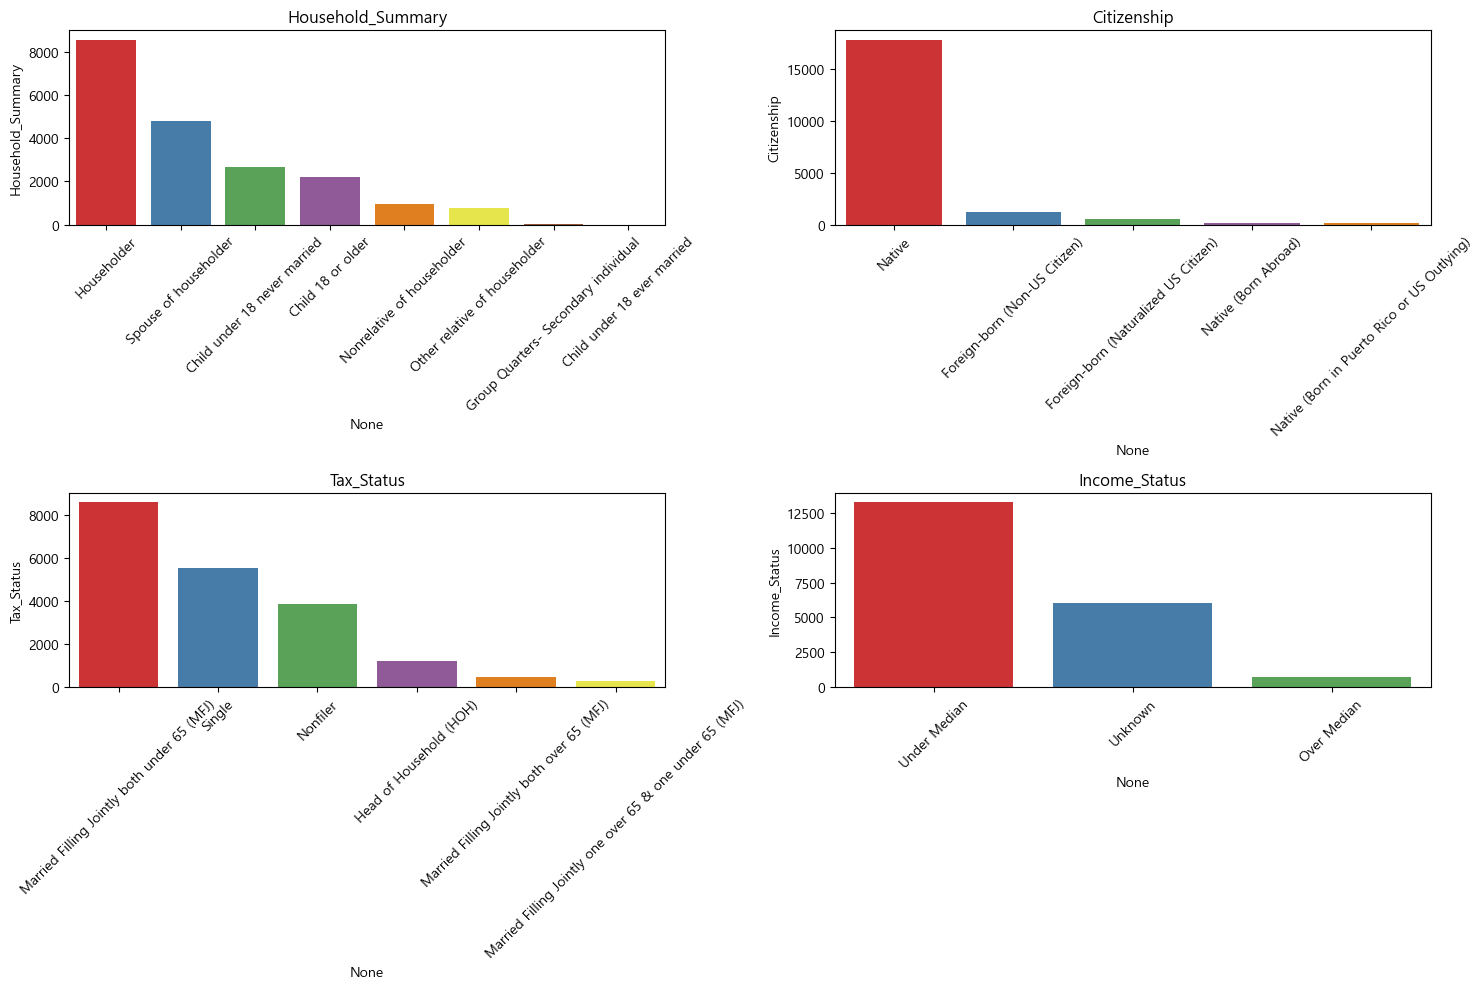

In [27]:
#(10) Industry_Status
f,ax = plt.subplots(2,2, figsize=(15,10))
lst = ['Household_Summary', 'Citizenship', 'Tax_Status', 'Income_Status']

for idx, feature in enumerate(lst):
    i = idx // 2  # subplot의 행 인덱스 계산 : 몫
    j = idx % 2   # subplot의 열 인덱스 계산 : 나머지
    sns.barplot(x=train[feature].value_counts().index, y=train[feature].value_counts(), hue=train[feature].value_counts().index, palette='Set1', ax=ax[i, j], legend=False)
    ax[i, j].tick_params(axis='x', rotation=45)
    ax[i, j].set_title(feature)  # subplot의 제목 설정

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

In [28]:
train['Occupation_Status'].value_counts()

Unknown                             4688
Admin Support (include Clerical)    2709
Services                            2313
Craft & Repair                      1869
Sales                               1692
Professional                        1488
Machine Operators & Inspectors      1383
Management                          1111
Handlers/Cleaners                    837
Transportation                       690
Technicians & Support                558
Farming & Forestry & Fishing         296
Protective Services                  260
Private Household Services           105
Armed Forces                           1
Name: Occupation_Status, dtype: int64

In [29]:
train['Industry_Status'].value_counts()

Not in universe or children                     4688
Retail                                          3149
Manufacturing (Durable)                         1575
Manufacturing (Non-durable)                     1223
Education                                       1041
Business & Repair                                847
Medical (except Hospitals)                       838
Construction                                     832
Hospitals                                        821
Finance Insurance & Real Estate                  727
Transportation                                   693
Public Administration                            641
Other professional services                      477
Wholesale                                        450
Personal Services (except Private Household)     429
Social Services                                  367
Entertainment                                    278
Agriculture                                      268
Utilities & Sanitary                          

In [30]:
train['Tax_Status'].value_counts() #미국 세금 관련 내용을 보고 도메인 파악하기

Married Filling Jointly both under 65 (MFJ)                 8588
Single                                                      5547
Nonfiler                                                    3874
Head of Household (HOH)                                     1217
Married Filling Jointly both over 65 (MFJ)                   469
Married Filling Jointly one over 65 & one under 65 (MFJ)     305
Name: Tax_Status, dtype: int64

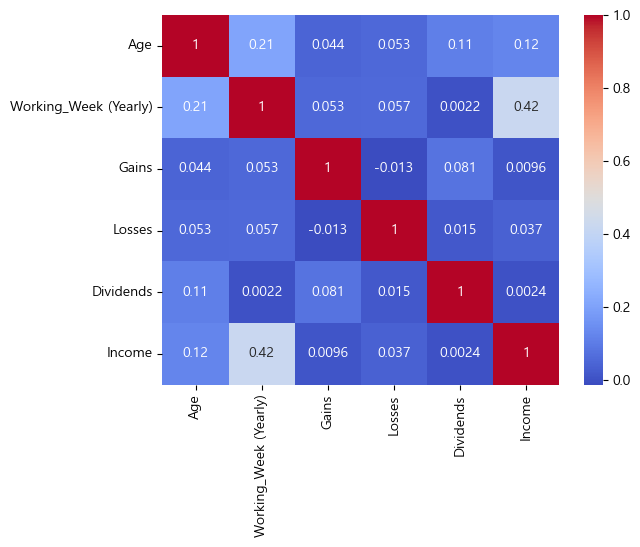

In [31]:
## 상관관계 확인
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()

일하는 시간과 소득의 연관관계가 0.42로 높은 편이다.

### 소득을 예측할 때 어떤 데이터가 중요할까? (도메인 이해)

- US, Native에 속하는 사람이 대다수임을 통해 US 국가에서 이루어지는 소득 예측임을 짐작할 수 있다.
- 직업 / 교육 수준 / 경력 / 지역 / 가족 상황 / 근로시간 / 추가 소득 / 성별 / 인종 
- 너무 변수가 많아서 한 번 진행해보고 feature importance로 차원 축소를 진행

## 전처리

### 범주형 전처리

In [172]:
print(len(train_1)) #119816
print(len(test_1)) #9911

19816
9911


In [173]:
#종속값 분리
y = train[['Income']]

train_1.drop(columns='Income', inplace=True)

In [174]:
#데이터셋을 합쳐서 범주형 전처리 진행
data = pd.concat([train_1, test_1], axis=0)

In [155]:
# data[data['Hispanic_Origin'] == ' Cuban']

pd.crosstab(data['Hispanic_Origin'], data['Birth_Country'])
#히스패닉 계통 데이터가 대부분 Latin, North 국가에서 출생되었고 데이터량이 적기 때문에 삭제
#다른 곳에서는 어떻게 풀었는지 궁금하다

Birth_Country,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong Kong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-U S (Guam USVI etc),Panama,Peru,Philippines,Poland,Portugal,Puerto-Rico,Scotland,South Korea,Taiwan,Thailand,Trinadad&Tobago,US,Unknown,Vietnam,Yugoslavia
Hispanic_Origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
All other,11,100,48,0,2,4,1,17,58,18,126,25,2,38,3,2,18,7,74,33,26,49,63,54,15,10,7,17,2,3,168,64,40,4,13,44,16,18,14,24798,404,44,12
Central or South American,1,0,0,44,0,14,35,67,0,0,0,0,32,1,0,10,1,0,0,0,0,0,2,0,0,5,23,1,2,26,0,0,1,3,0,0,0,0,0,105,86,0,0
Chicano,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0
Cuban,0,0,1,0,84,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,23,1,0,0
Do not know,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0
Mexican (Mexicano),0,0,0,0,0,0,0,3,4,0,0,0,2,0,0,1,2,0,0,0,0,0,0,0,0,719,0,0,0,0,0,0,0,1,0,0,0,0,0,205,3,0,0
Mexican-American,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,78,0,1,0,2,1,0,0,0,0,0,0,0,0,843,0,0,0
NA,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,2,1,0,0,0,4,0,0,0,0,0,0,0,0,75,1,0,0
Other Spanish,0,0,0,2,0,53,8,5,1,1,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,5,2,0,0,2,0,0,2,2,0,0,0,0,0,193,15,0,0


In [156]:
print(len(data[(data['Birth_Country'] != data['Birth_Country (Father)'])]))

print(len(data[(data['Birth_Country (Father)'] != data['Birth_Country (Mother)'])]))

print(len(data[(data['Birth_Country'] != data['Birth_Country (Mother)'])]))

2473
1707
2322


In [176]:
#직업상태 삭제
data.drop(columns='Occupation_Status', inplace=True)

#householder 삭제
data.drop(columns='Household_Status', inplace=True)
data.rename(columns={'Household_Summary': 'Household_Status'}, inplace=True)

#히스패닉 출식 삭제
data.drop(columns='Hispanic_Origin', inplace=True)

#income_status 삭제
data.drop(columns='Income_Status', inplace=True)

In [179]:
#부모 출생국가는 상관관계가 크고 본인의 출생국가보다 큰 영향을 끼치지 못한다고 판단하여 삭제
data.drop(columns='Birth_Country (Father)', inplace=True)
data.drop(columns='Birth_Country (Mother)', inplace=True)

In [180]:
#Education_Status 분류
def changing_data(column, value, change_value):
    data.loc[data[column] == value, column] = change_value

#유치원 이하 : Children, Kindergarten
changing_data('Education_Status', 'Kindergarten', 'Never_edu')
changing_data('Education_Status', 'Children', 'Never_edu')

# 초등학교 : Elementary (1-4), Elementary (5-6)
changing_data('Education_Status', 'Elementary (1-4)', 'Elementary')
changing_data('Education_Status', 'Elementary (5-6)', 'Elementary')

# 중고등학교 : High graduate, High Freshman, High Junior, High Sophomore, Middle(7-8), High Senior
changing_data('Education_Status', 'High graduate', 'Middle-High')
changing_data('Education_Status', 'High Freshman', 'Middle-High')
changing_data('Education_Status', 'High Junior', 'Middle-High')
changing_data('Education_Status', 'High Sophomore', 'Middle-High')
changing_data('Education_Status', 'Middle (7-8)', 'Middle-High')
changing_data('Education_Status', 'High Senior', 'Middle-High')

# 대학교(학사, 준학사) : Bachelors degree, Associates degree(Vocational), College, Associates degree(Academic)
changing_data('Education_Status', 'Bachelors degree', 'College')
changing_data('Education_Status', 'Associates degree (Vocational)', 'College')
changing_data('Education_Status', 'Associates degree (Academic)', 'College')

# 대학원(석사, 박사, 전문학사) : Master degree, Doctorate degree, Professional degree
changing_data('Education_Status', 'Masters degree', 'Graduate')
changing_data('Education_Status', 'Doctorate degree', 'Graduate')
changing_data('Education_Status', 'Professional degree', 'Graduate')

In [181]:
#고용형태 분류

#파트타임
changing_data('Employment_Status', 'Choice Part-Time', 'Part-Time')
changing_data('Employment_Status', 'Part-Time (Usually Part-Time)', 'Part-Time')
changing_data('Employment_Status', 'Part-Time (Usually Full-Time)', 'Part-Time')

#구직 중
changing_data('Employment_Status', 'Seeking Full-Time', 'Between Jobs')
changing_data('Employment_Status', 'Seeking Part-Time', 'Between Jobs')

In [182]:
#결혼여부
data['Martial_Status'] = data['Martial_Status'].apply(lambda x: 'Married' if 'married' in x.lower() else x)
changing_data('Martial_Status', 'Divorced', 'Have been married')
changing_data('Martial_Status', 'Widowed', 'Have been married')
changing_data('Martial_Status', 'Separated', 'Have been married')

In [183]:
#출생국가 확인
#북아메리카
changing_data('Birth_Country', 'US', 'North America')
changing_data('Birth_Country', 'Outlying-U S (Guam USVI etc)', 'North America')
changing_data('Birth_Country', 'Canada', 'North America')

#중남미
changing_data('Birth_Country', 'Cuba', 'Latin America')
changing_data('Birth_Country', 'Mexico', 'Latin America')
changing_data('Birth_Country', 'Puerto-Rico', 'Latin America')
changing_data('Birth_Country', 'Columbia', 'Latin America')
changing_data('Birth_Country', 'Trinadad&Tobago', 'Latin America')
changing_data('Birth_Country', 'Ecuador', 'Latin America')
changing_data('Birth_Country', 'Nicaragua', 'Latin America')
changing_data('Birth_Country', 'Peru', 'Latin America')
changing_data('Birth_Country', 'Jamaica', 'Latin America')
changing_data('Birth_Country', 'Dominican-Republic', 'Latin America')
changing_data('Birth_Country', 'Haiti', 'Latin America')
changing_data('Birth_Country', 'Guatemala', 'Latin America')
changing_data('Birth_Country', 'El-Salvador', 'Latin America')
changing_data('Birth_Country', 'Panama', 'Latin America')
changing_data('Birth_Country', 'Honduras', 'Latin America')

#동아시아
changing_data('Birth_Country', 'Japan', 'East Asia')
changing_data('Birth_Country', 'South Korea', 'East Asia')
changing_data('Birth_Country', 'China', 'East Asia')
changing_data('Birth_Country', 'Hong Kong', 'East Asia')
changing_data('Birth_Country', 'Taiwan', 'East Asia')

#유럽
changing_data('Birth_Country', 'Portugal', 'Europe')
changing_data('Birth_Country', 'Germany', 'Europe')
changing_data('Birth_Country', 'Italy', 'Europe')
changing_data('Birth_Country', 'England', 'Europe')
changing_data('Birth_Country', 'France', 'Europe')
changing_data('Birth_Country', 'Poland', 'Europe')
changing_data('Birth_Country', 'Scotland', 'Europe')
changing_data('Birth_Country', 'Yugoslavia', 'Europe')
changing_data('Birth_Country', 'Ireland', 'Europe')
changing_data('Birth_Country', 'Greece', 'Europe')
changing_data('Birth_Country', 'Hungary', 'Europe')

#남아시아 & 중동
changing_data('Birth_Country', 'Philippines', 'South&Middle Asia')
changing_data('Birth_Country', 'India', 'South&Middle Asia')
changing_data('Birth_Country', 'Vietnam', 'South&Middle Asia')
changing_data('Birth_Country', 'Cambodia', 'South&Middle Asia')
changing_data('Birth_Country', 'Laos', 'South&Middle Asia')
changing_data('Birth_Country', 'Thailand', 'South&Middle Asia')
changing_data('Birth_Country', 'Iran', 'South&Middle Asia')

In [184]:
#성별 대체
data['Gender'] = data['Gender'].replace({'M' : 0, 'F' : 1})

In [185]:
#학력 범주형 전환
data['Education_Status'] = data['Education_Status'].replace({'Never_edu' : 0, 'Elementary' : 1, 'Middle-High' : 2, 'College' : 3, 'Graduate' : 4})

In [186]:
#고용형태 범주형 전환
data['Employment_Status'] = data['Employment_Status'].replace({'Not Working' : 0, 'Children or Armed Forces' : 1, 'Between Jobs' : 2, 'Part-Time' : 3, 'Full-Time' : 4})

In [58]:
#원핫 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

def encoding(column):
    data[column] = encoder.fit_transform(data[column])
    print(f" {column} Encoded classes:", encoder.classes_)
    print()

In [59]:
encoding('Industry_Status')
encoding('Occupation_Status')
encoding('Race')
encoding('Martial_Status')
encoding('Household_Status')
encoding('Citizenship')
encoding('Birth_Country')
encoding('Birth_Country (Father)')
encoding('Birth_Country (Mother)')
encoding('Tax_Status')

encoding('Income_Status')

 Industry_Status Encoded classes: ['Agriculture' 'Armed Forces' 'Business & Repair' 'Communications'
 'Construction' 'Education' 'Entertainment'
 'Finance Insurance & Real Estate' 'Forestry & Fisheries' 'Hospitals'
 'Manufacturing (Durable)' 'Manufacturing (Non-durable)'
 'Medical (except Hospitals)' 'Mining' 'Not in universe or children'
 'Other professional services'
 'Personal Services (except Private Household)'
 'Private Household Services' 'Public Administration' 'Retail'
 'Social Services' 'Transportation' 'Utilities & Sanitary' 'Wholesale']

 Occupation_Status Encoded classes: ['Admin Support (include Clerical)' 'Armed Forces' 'Craft & Repair'
 'Farming & Forestry & Fishing' 'Handlers/Cleaners'
 'Machine Operators & Inspectors' 'Management'
 'Private Household Services' 'Professional' 'Protective Services' 'Sales'
 'Services' 'Technicians & Support' 'Transportation' 'Unknown']

 Race Encoded classes: ['Asian/Pacific' 'Black' 'Native American/Aleut/Eskimo' 'Other' 'White']

 Mar

In [60]:
data

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TRAIN_00000,63,0,2,4,4,20,11,4,1,4,2,4,4,4,4,0,0,0,2
1,TRAIN_00001,37,0,3,4,52,6,11,4,0,4,2,4,4,4,5,0,0,0,1
2,TRAIN_00002,58,1,2,4,52,11,0,1,1,4,2,4,4,4,2,3411,0,0,1
3,TRAIN_00003,44,0,2,4,52,19,12,4,0,4,2,4,4,4,5,0,0,0,1
4,TRAIN_00004,37,1,2,4,52,19,10,4,0,4,2,4,4,4,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TEST_9995,31,0,3,1,52,15,12,4,2,4,2,4,4,4,5,0,0,0,1
9996,TEST_9996,27,0,3,1,52,19,4,4,1,4,2,4,4,4,2,0,0,0,1
9997,TEST_9997,18,0,2,1,7,19,11,1,2,0,2,4,4,4,4,0,0,0,1
9998,TEST_9998,9,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,1


In [61]:
#되돌리기
train_en = data.iloc[:19969,:]
test_en = data.iloc[19969:,:]

In [65]:
train_en

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,63,0,2,4,4,20,11,4,1,4,2,4,4,4,4,0,0,0,2
1,37,0,3,4,52,6,11,4,0,4,2,4,4,4,5,0,0,0,1
2,58,1,2,4,52,11,0,1,1,4,2,4,4,4,2,3411,0,0,1
3,44,0,2,4,52,19,12,4,0,4,2,4,4,4,5,0,0,0,1
4,37,1,2,4,52,19,10,4,0,4,2,4,4,4,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,0,2,1,52,10,4,4,2,4,2,4,4,4,5,0,0,0,1
19996,20,1,3,4,12,5,0,4,2,0,2,4,3,3,4,0,0,0,1
19997,22,0,3,1,52,21,12,4,2,3,2,4,4,4,5,0,0,0,2
19998,76,1,2,0,0,14,14,4,0,4,2,4,1,1,5,0,0,0,1


In [62]:
test_en

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TEST_0000,79,0,2,1,0,14,14,4,2,4,2,4,6,6,5,0,0,0,1
1,TEST_0001,47,0,1,1,0,14,14,4,2,0,2,4,4,4,4,0,0,0,1
2,TEST_0002,18,1,2,1,52,19,11,4,2,0,2,4,4,4,5,0,0,0,1
3,TEST_0003,39,1,3,4,30,12,11,4,1,7,2,4,4,4,2,0,0,0,2
4,TEST_0004,6,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TEST_9995,31,0,3,1,52,15,12,4,2,4,2,4,4,4,5,0,0,0,1
9996,TEST_9996,27,0,3,1,52,19,4,4,1,4,2,4,4,4,2,0,0,0,1
9997,TEST_9997,18,0,2,1,7,19,11,1,2,0,2,4,4,4,4,0,0,0,1
9998,TEST_9998,9,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,1


In [63]:
#ID 삭제
train_en.drop(columns = 'ID', inplace=True)
test_en.drop(columns = 'ID', inplace=True)

C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\2452907762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_en.drop(columns = 'ID', inplace=True)
C:\Users\sori4\AppData\Local\Temp\ipykernel_5792\2452907762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_en.drop(columns = 'ID', inplace=True)


In [64]:
#전처리 다한 데이터 내보내기
train_en.to_csv("./train_data.csv")
test_en.to_csv("./test_data.csv")
y.to_csv("./y_data.csv")